## 1.0 Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib import cm, colors
sns.set_theme()

import os
os.chdir("..")
import init_simple_mdp as imdp
import init_load_board as ib

In [2]:
#epsilon_list = list(df.epsilon.unique())
epsilon_list = list(range(1,11))
epsilon_list_extremes = [25,50,100]

In [3]:
df = pd.read_csv('results/player10_noturn_results.csv')
df = df[['epsilon','tokens','score','optimal_value','optimal_policy']]

# Map to policy action names 
a_map = {i:imdp.a_list[i] for i in range(len(imdp.a_list))}
df['optimal_policy_name'] = df['optimal_policy'].map(a_map)

In [4]:
df0 = df.loc[df.tokens==0].copy()
df0['ppd'] = df0.score / df0.optimal_value

# Create dataframes for values at 501 for each token value 
epsilon_dfs = []

for e in range(len(epsilon_list)):
    epsilon = epsilon_list[e]
    temp = df0.loc[df0.epsilon==epsilon].set_index('score')['optimal_policy_name'].copy()
    epsilon_dfs.append(temp)

In [5]:
epsilon_dfs_expanded = []

for e in range(len(epsilon_list)):

    epsilon = epsilon_list[e]

    temp_list = []
    for action in epsilon_dfs[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded.append(temp)

## 2.0 Policy Heatmaps for Different Epsilon

### 2.1 Helpers

In [6]:
def createKde(data, x, y, title="", ax=None, cmap='Blues', levels=10, alpha=1):
    if ax == None:
        ax = plt.gca()
    sns.kdeplot(data=data, x=x, y=y, cmap=cmap, fill=True, levels=levels, ax=ax, alpha=alpha)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ib.plot_basic_board(axes=ax)
    ax.title.set_text(title)

In [7]:
import os 
import numpy as np
import math
import scipy.io as sio
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()

import init_load_board as ib
import init_simple_mdp as imdp

import function_board as fb
import function_tool as ft

def get_gaussian(x_val,y_val,error_multiplier,player_index=7):
  
  result_dir = fb.data_parameter_dir + '/grid_full'
  if not os.path.isdir(result_dir):
      os.makedirs(result_dir)
  player_parameter = sio.loadmat('./ALL_Model_Fits.mat')
  
  ## 1mm-width grid of 341*341 aiming locations (a sqaure enclosing the circle dart board)
  [xindex, yindex, xgrid, ygrid, grid_num] = fb.get_1mm_grid()

  xi = np.where(xgrid==x_val)[0][0]
  yi = np.where(xgrid==y_val)[0][0]

  ## select the proper Gaussian distribution according to the area to which the aiming location belongs
  mu = [xgrid[xi], ygrid[yi]]
  score, multiplier = fb.get_score_and_multiplier(mu)
  if (score==60 and multiplier==3): ##triple 20
      covariance_matrix = player_parameter['ModelFit_T20'][0, player_index][2] * error_multiplier
  elif (score==57 and multiplier==3): ##triple 19
      covariance_matrix = player_parameter['ModelFit_T19'][0, player_index][2] * error_multiplier
  elif (score==54 and multiplier==3): ##triple 18
      covariance_matrix = player_parameter['ModelFit_T18'][0, player_index][2] * error_multiplier
  elif (score==51 and multiplier==3): ##triple 17
      covariance_matrix = player_parameter['ModelFit_T17'][0, player_index][2] * error_multiplier
  elif (score==50 and multiplier==2): ##double bull
      covariance_matrix = player_parameter['ModelFit_B50'][0, player_index][2] * error_multiplier
  else:
      covariance_matrix = player_parameter['ModelFit_All_Doubles'][0, player_index][2] * error_multiplier
  
  return mu,covariance_matrix

def plot_gaussian(x_val,y_val,error_multiplier,player_index=7,xlim=(-200,200),ylim=(-200,200),figsize = (8,8),ax=None,title=''):
  
  mu,covariance_matrix = get_gaussian(x_val,y_val,error_multiplier,player_index=player_index)
  rv = multivariate_normal(mu, covariance_matrix)
  
  x, y = np.mgrid[-200:200:1, -200:200:1]
  pos = np.dstack((x, y))
  
  axes = ib.plot_basic_board(xlim=xlim,ylim=ylim,figsize = figsize,axes=ax)
  #axes.plot(x_val, y_val, "or")

  ax.title.set_text(title)
  
  fi = axes.contourf(x, y, rv.pdf(pos), 20, cmap='Greens')


### 2.2 High Epsilon

In [8]:
epsilon_dfs_expanded_extremes = []

for e in range(len(epsilon_list_extremes)):

    epsilon = epsilon_list_extremes[e]

    temp_list = []
    for action in epsilon_dfs[e]: 
        try: 
            temp_list.append([action,imdp.actions[action]['coords'][0],imdp.actions[action]['coords'][1]])
        except: 
            continue

    temp = pd.DataFrame(temp_list, columns = ['a','x','y'])
    
    epsilon_dfs_expanded_extremes.append(temp)

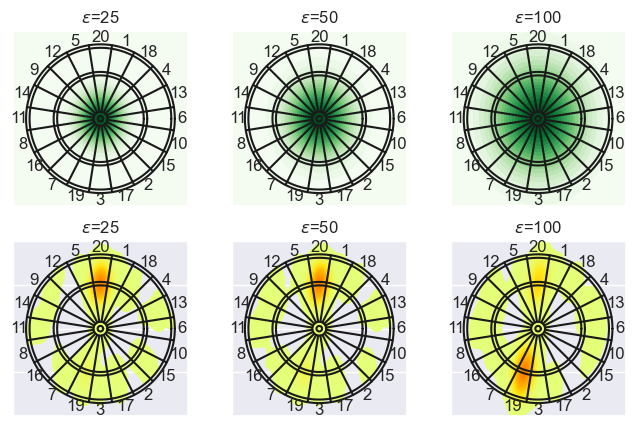

In [9]:
cmap = 'Wistia'
alpha = 1
levels = 50

x_val=0
y_val=0

epsilon_list = [25,50,100]

fig, ax = plt.subplots(2, 3, figsize=(8,5))

for e in range(len(epsilon_list)):
    col = e % 3
    plot_gaussian(x_val,y_val,epsilon_list_extremes[e],player_index=10,xlim=(-200,200),ylim=(-200,200),ax=ax[0,col],title='$\epsilon$={}'.format(epsilon_list_extremes[e]))
    createKde(data=epsilon_dfs_expanded_extremes[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list_extremes[e]), ax=ax[1,col], cmap=cmap, levels=levels, alpha=alpha)

    #plt.tight_layout()

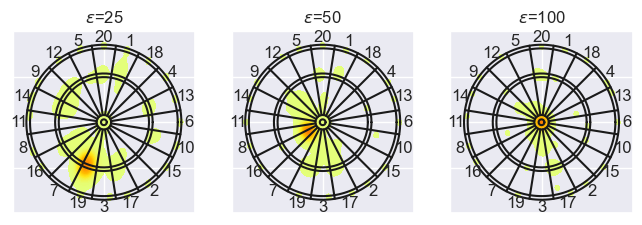

In [19]:

cmap = 'Wistia'
alpha = 1
levels = 50

fig, ax = plt.subplots(1, 3, figsize=(8,8))

for e in range(len(epsilon_list)):
    row = math.floor(e/3)
    col = e % 3
    createKde(data=epsilon_dfs_expanded[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list[e]), ax=ax[col], cmap=cmap, levels=levels, alpha=alpha)
    #createKde(data=epsilon_dfs_expanded[e], x='x', y='y', title="$\epsilon$={}".format(epsilon_list[e]), ax=ax[row,col], cmap=cmap, levels=levels, alpha=alpha)
    #plt.tight_layout()

### 2.3 Low Epsilon

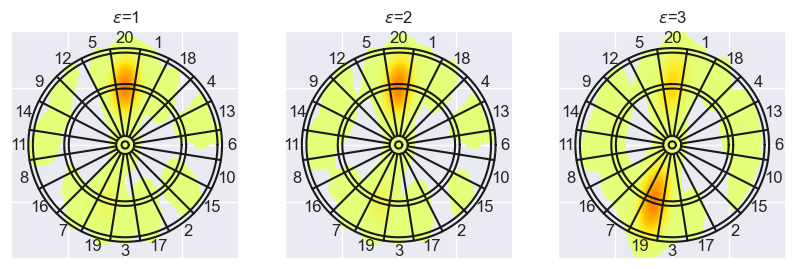

In [10]:
cmap = 'Wistia'
alpha = 1
levels = 50

fig, ax = plt.subplots(1, 3,figsize=(10,10))
createKde(data=epsilon_dfs_expanded[0], x='x', y='y', title="$\epsilon$=1", ax=ax[0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[1], x='x', y='y', title="$\epsilon$=2", ax=ax[1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[2], x='x', y='y', title="$\epsilon$=3", ax=ax[2], cmap=cmap, levels=levels, alpha=alpha)


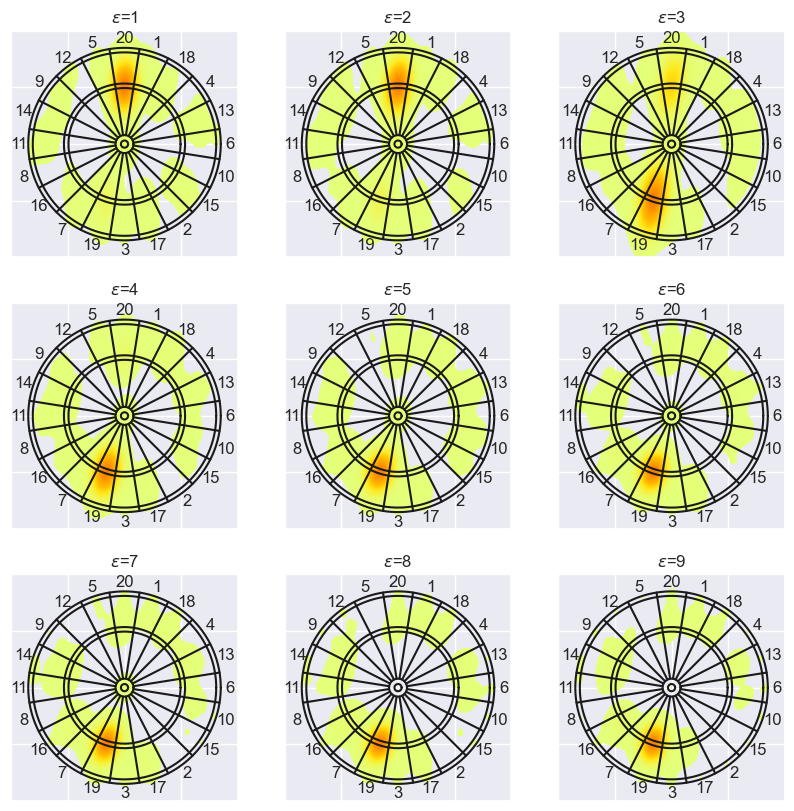

In [46]:

cmap = 'Wistia'
alpha = 1
levels = 50

fig, ax = plt.subplots(3, 3,figsize=(10,10))

createKde(data=epsilon_dfs_expanded[0], x='x', y='y', title="$\epsilon$=1", ax=ax[0,0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[1], x='x', y='y', title="$\epsilon$=2", ax=ax[0,1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[2], x='x', y='y', title="$\epsilon$=3", ax=ax[0,2], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[3], x='x', y='y', title="$\epsilon$=4", ax=ax[1,0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[4], x='x', y='y', title="$\epsilon$=5", ax=ax[1,1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[5], x='x', y='y', title="$\epsilon$=6", ax=ax[1,2], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[6], x='x', y='y', title="$\epsilon$=7", ax=ax[2,0], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[7], x='x', y='y', title="$\epsilon$=8", ax=ax[2,1], cmap=cmap, levels=levels, alpha=alpha)
createKde(data=epsilon_dfs_expanded[9], x='x', y='y', title="$\epsilon$=9", ax=ax[2,2], cmap=cmap, levels=levels, alpha=alpha)



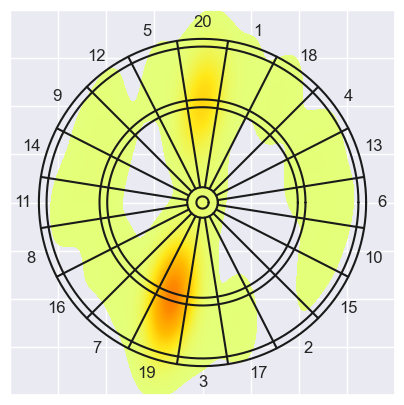

In [47]:
#fig = sns.set(rc={'figure.figsize':(5,5)})
ax = ib.plot_basic_board(figsize=(5,5))
cmap = 'Wistia'
alpha = 1
levels = 50
#thresh=0.02,

fig = sns.kdeplot(data=epsilon_dfs_expanded[2], x='x', y='y',  cmap=cmap, fill=True, levels=levels, ax=ax, alpha=alpha,warn_singular=False)
#fig = 

## 3. Policy Token Usage

In [11]:
# Add boolean column to indicate whether the policy uses tokens or not 
df['policy_is_token'] = df['optimal_policy'] >= imdp.throw_num

token_dfs = []

for epsilon in range(7):
    
    temp = df.loc[df.epsilon==epsilon].set_index('epsilon')['optimal_value'].copy()
    token_dfs.append(temp)


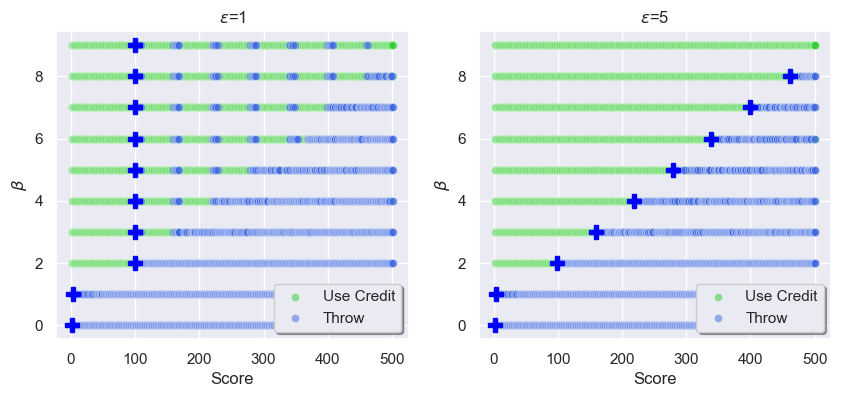

In [12]:
figure, ax = plt.subplots(1, 2,figsize=(10,4))

epsilon = 1
df_temp = df[df.optimal_policy != -1]
df_actions = df_temp[df_temp.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions.loc[df_actions.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[0])
fig = sns.scatterplot(data=df_actions.loc[df_actions.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[0])

fig = ax[0].set_ylabel(r'$\beta$')
fig = ax[0].set_xlabel(r'Score')
fig = ax[0].set_title(rf'$\epsilon$={epsilon}')
fig = ax[0].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions.loc[(df_actions.tokens==t) & (df_actions.policy_is_token==True)].score.max()
    min_throw = df_actions.loc[(df_actions.tokens==t) & (df_actions.policy_is_token==False)].score.min()
    # ax[0].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[0].plot(min_throw,t,marker='P',markersize=10,color='blue')

epsilon = 5
df_temp = df[df.optimal_policy != -1]
df_actions = df_temp[df_temp.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions.loc[df_actions.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen',ax=ax[1])
fig = sns.scatterplot(data=df_actions.loc[df_actions.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue',ax=ax[1])

fig = ax[1].set_ylabel(r'$\beta$')
fig = ax[1].set_xlabel(r'Score')
fig = ax[1].set_title(rf'$\epsilon$={epsilon}')
fig = ax[1].legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions.loc[(df_actions.tokens==t) & (df_actions.policy_is_token==True)].score.max()
    min_throw = df_actions.loc[(df_actions.tokens==t) & (df_actions.policy_is_token==False)].score.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    ax[1].plot(min_throw,t,marker='P',markersize=10,color='blue')


#fig = figure.suptitle(r'Optimal Use of Credits in Different States')



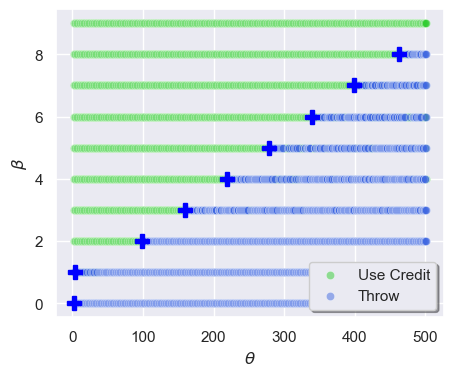

In [13]:
fig, ax = plt.subplots(1,1, figsize=(5,4))

epsilon = 5
df_temp = df[df.optimal_policy != -1]
df_actions = df_temp[df_temp.epsilon == epsilon]

#sns.set(rc={'figure.figsize':(6,4)})
fig = sns.scatterplot(data=df_actions.loc[df_actions.policy_is_token==True], x="score",y="tokens",alpha=0.5,label='Use Credit',color='limegreen')
fig = sns.scatterplot(data=df_actions.loc[df_actions.policy_is_token==False], x="score",y="tokens",alpha=0.5,label='Throw',color='royalblue')

f = fig.set_ylabel(r'$\beta$')
f = fig.set_xlabel(r'$\theta$')
#f = fig.set_title(rf'$\epsilon$={epsilon}')
f = fig.legend(loc='lower right', fancybox=True, shadow=True)

max_token_list = []
min_throw_list = []
for t in range(10):
    max_token = df_actions.loc[(df_actions.tokens==t) & (df_actions.policy_is_token==True)].score.max()
    min_throw = df_actions.loc[(df_actions.tokens==t) & (df_actions.policy_is_token==False)].score.min()
    #ax[1].plot(max_token,t,marker='X',markersize=10,color='green')
    fig.plot(min_throw,t,marker='P',markersize=10,color='blue')



In [15]:
temp.to_csv('results/player10_e1_noturn_results.csv')

In [31]:
temp[(temp.tokens==4)][150:170]

,epsilon,tokens,score,optimal_value,optimal_policy,optimal_policy_name,policy_is_token
2158,1,4,150,3.0,750,DB,True
2159,1,4,151,3.0,750,DB,True
2160,1,4,152,3.0,771,T20,True
2161,1,4,153,3.0,771,T20,True
2162,1,4,154,3.0,750,DB,True
2163,1,4,155,3.0,771,T20,True
2164,1,4,156,3.0,771,T20,True
2165,1,4,157,3.0,750,DB,True
2166,1,4,158,3.0,771,T20,True
2167,1,4,159,4.0,10,T20-c-m,False


In [165]:
df_actions.loc[(df_actions.tokens==4)]

,epsilon,tokens,score,optimal_value,optimal_policy,optimal_policy_name,policy_is_token
22090,5,4,2,1.000000,752,D1,True
22091,5,4,3,2.000000,730,S1,True
22092,5,4,4,1.000000,759,D2,True
22093,5,4,5,2.000000,730,S1,True
22094,5,4,6,1.000000,761,D3,True
...,...,...,...,...,...,...,...
22585,5,4,497,18.591299,406,T19-c-m,False
22586,5,4,498,18.647751,771,T20,True
22587,5,4,499,18.696884,406,T19-c-m,False
22588,5,4,500,18.748401,406,T19-c-m,False


In [ ]:
df_actions.loc[(df_actions.tokens==3) & (df_actions.policy_is_token==True)].score.max()

494

In [ ]:
df_actions.loc[(df_actions.tokens==3) & (df_actions.policy_is_token==True)].score.max()

In [23]:
df_actions.loc[(df_actions.tokens==3)][-20:-1]

,epsilon,tokens,score,optimal_value,optimal_policy,optimal_policy_name,policy_is_token
22068,5,3,482,19.958934,406,T19-c-m,False
22069,5,3,483,20.011446,406,T19-c-m,False
22070,5,3,484,20.061398,406,T19-c-m,False
22071,5,3,485,20.116233,406,T19-c-m,False
22072,5,3,486,20.169878,406,T19-c-m,False
22073,5,3,487,20.219640,771,T20,True
22074,5,3,488,20.273550,406,T19-c-m,False
22075,5,3,489,20.327911,406,T19-c-m,False
22076,5,3,490,20.377653,406,T19-c-m,False
22077,5,3,491,20.430760,406,T19-c-m,False


In [49]:
df_actions.loc[(df_actions.tokens==5)][150:170]

,epsilon,tokens,score,optimal_value,optimal_policy,optimal_policy_name,policy_is_token
22742,5,5,152,3.0,771,T20,True
22743,5,5,153,3.0,771,T20,True
22744,5,5,154,3.0,750,DB,True
22745,5,5,155,3.0,771,T20,True
22746,5,5,156,3.0,771,T20,True
22747,5,5,157,3.0,750,DB,True
22748,5,5,158,3.0,771,T20,True
22749,5,5,159,4.0,729,S20,True
22750,5,5,160,3.0,750,DB,True
22751,5,5,161,3.0,771,T20,True


In [177]:
lists = [[i for i in range(1,21)],[2*i for i in range(1,21)],[3*i for i in range(1,21)]]
full_range = set([i for i in range(1,61)])
union = set().union(*lists)
print(union)

diff = full_range.difference(union)
print(diff)


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 30, 32, 33, 34, 36, 38, 39, 40, 42, 45, 48, 51, 54, 57, 60}
{23, 25, 29, 31, 35, 37, 41, 43, 44, 46, 47, 49, 50, 52, 53, 55, 56, 58, 59}


In [185]:
diff_list = list(diff)
[99 / i for i in diff_list]

[4.304347826086956,
 3.96,
 3.413793103448276,
 3.193548387096774,
 2.8285714285714287,
 2.675675675675676,
 2.4146341463414633,
 2.302325581395349,
 2.25,
 2.152173913043478,
 2.106382978723404,
 2.020408163265306,
 1.98,
 1.9038461538461537,
 1.8679245283018868,
 1.8,
 1.7678571428571428,
 1.706896551724138,
 1.6779661016949152]

In [9]:
df.loc[(df.epsilon==1) & (df.tokens==4) & (df.score==162)]

,epsilon,tokens,score,optimal_value,optimal_policy,optimal_policy_name
2170,1,4,162,4.0,132,SI4-cw-o
